<a href="https://colab.research.google.com/github/giyushino/clip-vit-large-patch14-batch/blob/main/concise_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install torch
!pip install datasets
from transformers import CLIPProcessor, CLIPModel
import torch
from datasets import load_dataset
import torch.optim as optim
import torch.nn.functional as F
import time

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
# Load cifar10 dataset and extract labels
datasets = load_dataset("cifar10")

labels = datasets["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [3]:
#Load model and processor from Hugging Face's transformers library
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [36]:
# Function to batch large datasets into smaller groups for easier computation
def homemade_batch(num_img, batch_size=10, start_img=0, data_type = "test"):
    # Initialize empty set to store predicted values and their probabilities
    homemade = []
    num_batches = num_img // batch_size
    extra = num_img % batch_size # Not implemented yet

    # Allows computations to be run on GPU instead of CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    t_0 = time.perf_counter()

    for i in range(num_batches):
        t1 = time.perf_counter()

        # Create a temporary batch of data
        subset = datasets[data_type].select(range((i * batch_size + start_img), (i + 1) * batch_size + start_img))
        input = processor(text=labels, images=subset["img"], return_tensors="pt", padding=False).to(device)
        output = model(**input)

        # Access logits of the input images, apply softmax function
        logits = output.logits_per_image
        probs = logits.softmax(dim=1)

        # Find maximum of the probabilities, as well as their corresponding index, append them to list
        max_prob, max_id = probs.max(dim=1)
        homemade.append([max_prob.cpu().detach(), max_id.cpu().detach()])
        torch.cuda.empty_cache()

        if i % 50 == 0:
          t2 = time.perf_counter()
          print(f"Finished batch {i + 1} of {num_batches} in {t2 - t1} seconds")

    t_3 = time.perf_counter()
    print(f"Finished entire dataset in {t_3 - t_0} seconds")

    # Returns list of tensors, structure is [[tensor([first batch maximum probabilities]), tensor([corresponding indices/labels])],
    #                                         [tensor([second batch maximum probabilities]), tensor([corresponding indices/labels])],
    #                                         [tensor([third batch maximum probabilities]), tensor([corresponding indices/labels])]]
    return homemade

In [6]:
# Takes output of homemade_batch as input and returns clean data
def prediction_reformat(subset):
    # Initialize empty list to store new reformatted data
    predicted = []
    count = 0

    # len(subset) = number of batches
    for i in range(len(subset)):
        for k in range(len(subset[0][0])):
            prob = subset[i][0][k].item()
            id = subset[i][1][k].item()

            label = id2label[id]
            predicted.append([count, label, prob, id])

            count += 1

    # Returns nested list with form [[index, "label", probability, id],
    #                                [index, "label", probability, id]]
    return predicted

In [27]:
# Computes how accurate the model is
def accuracy(result, data_type = "test"):
    correct = 0
    total = 0

    # Create dictionary to count how many of each label occurs in the subset, all labels initialized to 0
    all_labels = {}
    for label in datasets[data_type].features["label"].names:
        all_labels[label] = 0

    # Dictionary to keep track of which classes were incorrectly predicted
    incorrect = {}
    for label in datasets[data_type].features["label"].names:
        incorrect[label] = 0

    # Iterate through the results for each image in the subset
    for i in range(len(result)):
        # Automatically increase count of label in dictionary for appearing
        all_labels[result[i][1]] += 1

        # If the actual id/label aligns with the predicted one, add to correct count
        if datasets[data_type][i]["label"] == result[i][3]:
            correct += 1
            total += 1
            if total % 50 == 0:
              print(f"Model accurately predicted {result[i][1]} with {result[i][2] * 100}% confidence.")
        else:
            # If they do not align, increase count of predicted id/label in incorrect dictionary
            total += 1
            if total % 50 == 0:
              print(f"Model inaccurately predicted {result[i][1]} with {result[i][2] * 100}% confidence.")
            incorrect[result[i][1]] += 1

    print(f"Accuracy: {(correct/total) * 100}%")

    worst_accuracy = []
    # For every label, calculate percentage predicted correctly by subtracting total by incorrect
    for label in all_labels:
        correct =  all_labels[label] - incorrect[label]
        total = all_labels[label]
        print(f"For {label}: Predicted {correct} out of {total} correct. {(correct) / total * 100}% Accuracy")
        worst_accuracy.append([label, correct/total])

    worst_group = min(worst_accuracy, key=lambda x: x[1])
    print(f"The worst performing group is '{worst_group[0]}' with an accuracy of {worst_group[1] * 100}%")

In [28]:
def data_analysis(predictions, data_type = "test"):
    cleaned = prediction_reformat(predictions)
    final_results = accuracy(cleaned, data_type)

    return final_results

In [35]:
# Train model on training dataset
def train(num_img, batch_size=10, num_epoch=2):
    # Set up training parameters
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    total_loss = 0
    model.to(device)
    model.train()


    for epoch in range(num_epoch):
        t0 = time.perf_counter()
        epoch_loss = 0

        # Separate training data into smaller batches
        for i in range(num_img // batch_size):
            train_set = datasets["train"].select(range(i * batch_size, (i + 1) * batch_size))
            t1 = time.perf_counter()

            # Process the data, feed it into the model
            input = processor(text=labels, images=train_set["img"], return_tensors="pt", padding=False).to(device)
            output = model(**input)

            # Get the logit for the predictions on the image and text
            logits_per_image = output.logits_per_image
            logits_per_text = output.logits_per_text
            # Turn this tensor from batch_size x 1 matrix to 1 x batch_size (doesn't work otherwise)
            logits_per_text = logits_per_text.squeeze()

            # Accesses the ground truth
            targets = torch.tensor(train_set["label"]).to(device)

            # Uses the cross-loss entropy function to calculate the loss of the images and text, utilizes softmax activation
            loss_img = F.cross_entropy(logits_per_image, targets)
            loss_text = F.cross_entropy(logits_per_text, targets)

            # Calculate the total loss
            loss = (loss_img + loss_text) / 2
            t2 = time.perf_counter()
            if i % 50 == 0:
              print(f"Finished batch {i + 1}/{num_img // batch_size} in {t2 - t1} seconds")

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        t3 = time.perf_counter()
        total_loss += epoch_loss
        avg_loss = epoch_loss / (num_img // batch_size)
        print(f"Epoch {epoch+1}/{num_epoch} completed in {t3 - t1} seconds, Loss: {avg_loss:.4f}")

In [14]:
pretrained = homemade_batch(100)
print(pretrained)

Finished batch 1 of 10 in 0.5900646970000025 seconds
Finished batch 2 of 10 in 0.673776308999976 seconds
Finished batch 3 of 10 in 0.6577476049999973 seconds
Finished batch 4 of 10 in 0.6650008029999981 seconds
Finished batch 5 of 10 in 0.6635283720000018 seconds
Finished batch 6 of 10 in 0.665469977000015 seconds
Finished batch 7 of 10 in 0.6655446760000245 seconds
Finished batch 8 of 10 in 0.670577714999979 seconds
Finished batch 9 of 10 in 0.6662438670000199 seconds
Finished batch 10 of 10 in 0.6646124359999988 seconds
Finished entire dataset in 6.5851677050000035 seconds
[[tensor([0.1826, 0.9470, 0.7625, 0.6686, 0.9949, 0.2969, 0.4471, 0.9872, 0.7945,
        0.7479]), tensor([7, 8, 8, 0, 6, 3, 1, 6, 3, 9])], [tensor([0.6933, 0.9869, 0.9555, 0.9935, 0.9839, 0.8149, 0.8525, 0.9886, 0.7258,
        0.9968]), tensor([2, 9, 5, 7, 9, 8, 5, 7, 8, 6])], [tensor([0.9928, 0.5041, 0.9784, 0.7642, 0.9178, 0.8165, 0.9942, 0.3571, 0.9978,
        0.9862]), tensor([7, 0, 4, 9, 5, 2, 4, 5, 9, 6])

In [17]:
pretrained_reformat = prediction_reformat(pretrained)

In [19]:
pretrained_reformat[0:10]

[[0, 'horse', 0.1826408952474594, 7],
 [1, 'ship', 0.9470039010047913, 8],
 [2, 'ship', 0.7625169157981873, 8],
 [3, 'airplane', 0.6686084270477295, 0],
 [4, 'frog', 0.9949457049369812, 6],
 [5, 'cat', 0.29691317677497864, 3],
 [6, 'automobile', 0.4470512866973877, 1],
 [7, 'frog', 0.9871699810028076, 6],
 [8, 'cat', 0.7945026159286499, 3],
 [9, 'truck', 0.7478898763656616, 9]]

1


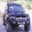

In [22]:
print(datasets["test"][9]["label"])
datasets["test"][9]["img"]

In [30]:
accuracy(pretrained_reformat)

Model accurately predicted frog with 99.14552569389343% confidence.
Model accurately predicted horse with 98.48936200141907% confidence.
Accuracy: 88.0%
For airplane: Predicted 6 out of 6 correct. 100.0% Accuracy
For automobile: Predicted 5 out of 5 correct. 100.0% Accuracy
For bird: Predicted 8 out of 10 correct. 80.0% Accuracy
For cat: Predicted 7 out of 8 correct. 87.5% Accuracy
For deer: Predicted 6 out of 7 correct. 85.71428571428571% Accuracy
For dog: Predicted 8 out of 12 correct. 66.66666666666666% Accuracy
For frog: Predicted 13 out of 13 correct. 100.0% Accuracy
For horse: Predicted 11 out of 13 correct. 84.61538461538461% Accuracy
For ship: Predicted 13 out of 13 correct. 100.0% Accuracy
For truck: Predicted 11 out of 13 correct. 84.61538461538461% Accuracy
The worst performing group is 'dog' with an accuracy of 66.66666666666666%


In [31]:
data_analysis(pretrained, data_type = "test")

Model accurately predicted frog with 99.14552569389343% confidence.
Model accurately predicted horse with 98.48936200141907% confidence.
Accuracy: 88.0%
For airplane: Predicted 6 out of 6 correct. 100.0% Accuracy
For automobile: Predicted 5 out of 5 correct. 100.0% Accuracy
For bird: Predicted 8 out of 10 correct. 80.0% Accuracy
For cat: Predicted 7 out of 8 correct. 87.5% Accuracy
For deer: Predicted 6 out of 7 correct. 85.71428571428571% Accuracy
For dog: Predicted 8 out of 12 correct. 66.66666666666666% Accuracy
For frog: Predicted 13 out of 13 correct. 100.0% Accuracy
For horse: Predicted 11 out of 13 correct. 84.61538461538461% Accuracy
For ship: Predicted 13 out of 13 correct. 100.0% Accuracy
For truck: Predicted 11 out of 13 correct. 84.61538461538461% Accuracy
The worst performing group is 'dog' with an accuracy of 66.66666666666666%


In [32]:
train(1000)

Finished batch 1/100 in 0.6165004450000424 seconds
Finished batch 2/100 in 0.5417150429999538 seconds
Finished batch 3/100 in 0.5540577250000069 seconds
Finished batch 4/100 in 0.5661609789999602 seconds
Finished batch 5/100 in 0.561250876000031 seconds
Finished batch 6/100 in 0.5648981820000927 seconds
Finished batch 7/100 in 0.5721515760000102 seconds
Finished batch 8/100 in 0.5638740570000209 seconds
Finished batch 9/100 in 0.5765367949999245 seconds
Finished batch 10/100 in 0.5830238370000416 seconds
Finished batch 11/100 in 0.5846940689999656 seconds
Finished batch 12/100 in 0.5932157539999707 seconds
Finished batch 13/100 in 0.5882356609999988 seconds
Finished batch 14/100 in 0.6021726680000938 seconds
Finished batch 15/100 in 0.6022816349999403 seconds
Finished batch 16/100 in 0.5937285210000027 seconds
Finished batch 17/100 in 0.5921023029999333 seconds
Finished batch 18/100 in 0.5934242939999876 seconds
Finished batch 19/100 in 0.5924799770000391 seconds
Finished batch 20/100 

In [33]:
model.eval()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

In [34]:
trained = homemade_batch(100)
data_analysis(trained, data_type = "test")

Finished batch 1 of 10 in 0.6963838240001223 seconds
Finished batch 2 of 10 in 0.6642155389999971 seconds
Finished batch 3 of 10 in 0.6559329930000786 seconds
Finished batch 4 of 10 in 0.6756326089998765 seconds
Finished batch 5 of 10 in 0.659053879999874 seconds
Finished batch 6 of 10 in 0.7022876360001646 seconds
Finished batch 7 of 10 in 0.6700707250001869 seconds
Finished batch 8 of 10 in 0.6810152259999995 seconds
Finished batch 9 of 10 in 0.6829351040000802 seconds
Finished batch 10 of 10 in 0.7069208929999604 seconds
Finished entire dataset in 6.797187052000027 seconds
Model accurately predicted frog with 72.41834998130798% confidence.
Model accurately predicted horse with 74.16436076164246% confidence.
Accuracy: 90.0%
For airplane: Predicted 9 out of 10 correct. 90.0% Accuracy
For automobile: Predicted 4 out of 4 correct. 100.0% Accuracy
For bird: Predicted 7 out of 7 correct. 100.0% Accuracy
For cat: Predicted 9 out of 11 correct. 81.81818181818183% Accuracy
For deer: Predicte